# Основы глубинного обучения, майнор ИАД

## Домашнее задание 1. Введение в PyTorch. Полносвязные нейронные сети.

### Общая информация

Дата выдачи: 01.10.2023

Мягкий дедлайн: 23:59MSK 15.10.2023

Жесткий дедлайн: 23:59MSK 20.10.2023

### Оценивание и штрафы
Максимально допустимая оценка за работу — 10 баллов. За каждый день просрочки снимается 1 балл. Сдавать задание после жёсткого дедлайна сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.
Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

Итогова оценка считается как
$$
min(task_1, task_2)*0.8 + max(task_1, task_2)*0.2
$$

где task_1 и task_2 - оценки за первое и второе заданиее соответсвенно.
Также, за домашнее задание выставляется 0, если не сделано нулевое или третье задание.
### О задании

В этом задании вам предстоит предсказывать год выпуска песни (**задача регрессии**) по некоторым звуковым признакам: [данные](https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd). В ячейках ниже находится код для загрузки данных. Обратите внимание, что обучающая и тестовая выборки располагаются в одном файле, поэтому НЕ меняйте ячейку, в которой производится деление данных.

In [45]:
import math

import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
import random
from tqdm.auto import tqdm
from collections import namedtuple
import math
import os

device = "cuda" if torch.cuda.is_available() else "cpu"
from tqdm.notebook import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [3]:
device

'cuda'

In [ ]:
!wget -O data1.txt.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip

In [4]:
df = pd.read_csv('data.txt.zip', header=None)
df.head(6)

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903
5,2001,50.54767,0.31568,92.35066,22.38696,-25.51870,-19.04928,20.67345,-5.19943,3.63566,...,6.59753,-50.69577,26.02574,18.94430,-0.33730,6.09352,35.18381,5.00283,-11.02257,0.02263


Мы вывели кусок данных, чтобы понять, насколько они пригодны для работы без изменений. Здесь ясно, что сомнительно дальше с такими данными работать, потому что как минимум есть отрицательные значения, которые не отмасштабированы, кроме того еще сразу бросается в глаза совсем разная размерность, где-то видим реально большие числа, а где-то 0.075. Ясно, что будем скейлить.

In [5]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

## Задание 0. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Мы будем использовать RMSE как метрику качества. Для самого первого бейзлайна обучите `Ridge` регрессию из `sklearn`. Кроме того, посчитайте качество при наилучшем константном прогнозе.

Для выполнения данного задания (и всех последующих) предобработайте данные.

1. Зафиксируйте random_seed везде где только возможно. Вам предоставлена функция для этого, однако вы можете дополнить ее своими дополнениями
2. Обучите StandertScaler и предобработайте ваши данные. В следующих заданиях можете использовать другой scaler или вообще отказаться от него


In [6]:
from sklearn.preprocessing import StandardScaler

# Скалирование
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [7]:
def set_random_seed(seed):
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [8]:
set_random_seed(42)

In [9]:
from sklearn.linear_model import Ridge
from sklearn.metrics import root_mean_squared_error

# Ridge model
# Не стану подбирать гиперпараметр alpha

model = Ridge()
rmse_for_model = root_mean_squared_error

model.fit(X_train_scaled, y_train)
train_score = rmse_for_model(y_train, model.predict(X_train_scaled))
test_score = rmse_for_model(y_test, model.predict(X_test_scaled))
print(f"{train_score=}")
print(f"{test_score=}")

train_score=9.552822967970322
test_score=9.510160820470436


Лучшая константа для RMSE это среднее, посчитаем значение метрики при нем

In [10]:
# Average constant model test

average = np.mean(y_train)

best_rmse_metric_train = rmse_for_model(y_train, np.full_like(y_train, average))
best_rmse_metric_test = rmse_for_model(y_test, np.full_like(y_test, average))
print(f"{best_rmse_metric_train=}")
print(f"{best_rmse_metric_test=}")

best_rmse_metric_train=10.946566221164124
best_rmse_metric_test=10.863228020678134


## Задание 1. (максимум 10 баллов)

Закрепите свои знания о том, как pytorch работает с обратным распространением ошибки, проделав следующие шаги:

1. Создайте модель линейной регрессии, которая будет состоять только из одного Linear слоя.
2. Напишите цикл обучения вашей линейной регрессии. В нем реализуйте подсчет функции потерь, сделайте шаг градиентного спуска. Запрещено использовать готовые оптимизаторы и loss-функции из библиотеки pytorch. Для подсчета градиента воспользуйтесь методом backward.
3. Запустите обучение на 10 эпохах, после каждой проверяйте значение целевой метрики на тестовой выборке.
4. Выведите на экран графики метрики и значения функции потерь на тестовой и обучающей выборке.

В данном задании нет цели побить какой-то порог по метрике. Ваша задача - убедиться в том, что ваш рукописный цикл обучения работает. Для ускорения вычислений и обучения модели можете брать только срез данных, а не весь датасет.

In [11]:
learning_rate = 0.05
epoch = 100  # возьму 100, а не 10, чтобы качественно обучить и сравнить с прошлыми заданиями

# init
w = torch.rand(X_train.shape[1], requires_grad=True)  # weight
b = torch.rand(1, requires_grad=True)  # bias

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)  # data
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)  # target

X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)  # data
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)  # target

losses_train, losses_test = [], []

for e in tqdm(range(epoch)):
    # pred
    y_pred = torch.matmul(X_train_tensor, w) + b
    loss = torch.mean((y_pred - y_train_tensor) ** 2)
    loss.backward()

    # Validation
    with torch.no_grad():
        losses_train.append(torch.sqrt(loss).item())  # RMSE
        y_pred_test = torch.matmul(X_test_tensor, w) + b
        losses_test.append(torch.sqrt(torch.mean((y_pred_test - y_test_tensor) ** 2)).item())  # RMSE

        # step
        w.data -= learning_rate * w.grad
        b.data -= learning_rate * b.grad

    # zero grad
    w.grad.data.zero_()
    b.grad.data.zero_()
    
    print(f"epoch {e+1}, train {losses_train[-1]}, test {losses_test[-1]}")
# Результаты почти как в sklearn, не хватило только немного регуляризации

  0%|          | 0/100 [00:00<?, ?it/s]

epoch 1, train 1997.82666015625, test 1997.8837890625
epoch 2, train 1798.041259765625, test 1798.18994140625
epoch 3, train 1618.24169921875, test 1618.35986328125
epoch 4, train 1456.4232177734375, test 1456.525634765625
epoch 5, train 1310.7874755859375, test 1310.8785400390625
epoch 6, train 1179.71630859375, test 1179.798828125
epoch 7, train 1061.753173828125, test 1061.828857421875
epoch 8, train 955.58740234375, test 955.657470703125
epoch 9, train 860.0392456054688, test 860.104736328125
epoch 10, train 774.0471801757812, test 774.108642578125
epoch 11, train 696.6556396484375, test 696.7136840820312
epoch 12, train 627.004638671875, test 627.0597534179688
epoch 13, train 564.3203125, test 564.3727416992188
epoch 14, train 507.9062805175781, test 507.95635986328125
epoch 15, train 457.13555908203125, test 457.18353271484375
epoch 16, train 411.44415283203125, test 411.49017333984375
epoch 17, train 370.3241882324219, test 370.368408203125
epoch 18, train 333.31890869140625, te

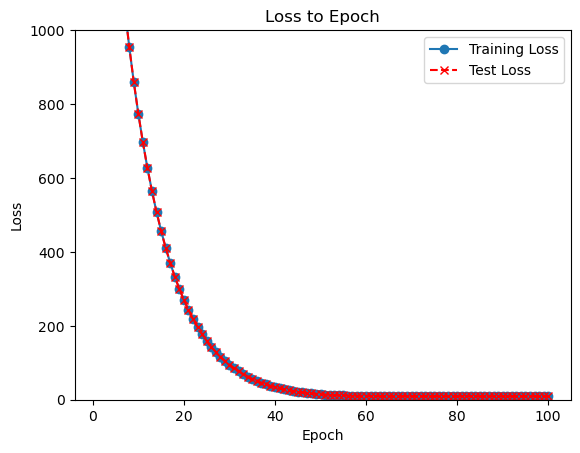

In [12]:
# visualization
plt.plot(range(1, len(losses_train) + 1), losses_train, label='Training Loss', marker='o', linestyle='-')
plt.plot(range(1, len(losses_test) + 1), losses_test, label='Test Loss', color='red', marker='x', linestyle='--')

# labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss to Epoch')

plt.legend()
plt.ylim(0, 1000)

# Displaying the plot
plt.show()

# Модель хорошо обучилась. 
# Тестовая валидация видимо накладывается на лосс тренировочной выборки из за похожести данных между собой и большого количества данных

## Задание 2. (максимум 10 баллов)

Реализуйте обучение и тестирование нейронной сети для предоставленного вам набора данных. Соотношение между полученным значением метрики на тестовой выборке и баллами за задание следующее:

- $\text{RMSE} \le 9.00 $ &mdash; 4 балла
- $\text{RMSE} \le 8.90 $ &mdash; 6 баллов
- $\text{RMSE} \le 8.80 $ &mdash; 8 баллов
- $\text{RMSE} \le 8.75 $ &mdash; 10 баллов

Есть несколько правил, которых вам нужно придерживаться:

- Весь пайплайн обучения должен быть написан на PyTorch. При этом вы можете пользоваться другими библиотеками (`numpy`, `sklearn` и пр.), но только для обработки данных. То есть как угодно трансформировать данные и считать метрики с помощью этих библиотек можно, а импортировать модели из `sklearn` и выбивать с их помощью требуемое качество &mdash; нельзя. Также нельзя пользоваться библиотеками, для которых сам PyTorch является зависимостью.

- Мы никак не ограничиваем ваш выбор архитектуры модели, но скорее всего вам будет достаточно полносвязной нейронной сети.

- Для обучения запрещается использовать какие-либо иные данные, кроме обучающей выборки.

- Ансамблирование моделей запрещено.

### Полезные советы:

- Очень вряд ли, что у вас с первого раза получится выбить качество на 10 баллов, поэтому пробуйте разные архитектуры, оптимизаторы и значения гиперпараметров. В идеале при запуске каждого нового эксперимента вы должны менять что-то одно, чтобы точно знать, как этот фактор влияет на качество.

- Не забудьте, что для улучшения качества модели вам поможет **нормировка таргета**.

- Тот факт, что мы занимаемся глубинным обучением, не означает, что стоит забывать про приемы, использующиеся в классическом машинном обучении. Так что обязательно проводите исследовательский анализ данных, отрисовывайте нужные графики и не забывайте про масштабирование и подбор гиперпараметров.

- Вы наверняка столкнетесь с тем, что ваша нейронная сеть будет сильно переобучаться. Для нейросетей существуют специальные методы регуляризации, например, dropout ([статья](https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)) и weight decay ([блогпост](https://towardsdatascience.com/weight-decay-l2-regularization-90a9e17713cd)). Они, разумеется, реализованы в PyTorch. Попробуйте поэкспериментировать с ними.

- Если вы чего-то не знаете, не гнушайтесь гуглить. В интернете очень много полезной информации, туториалов и советов по глубинному обучению в целом и по PyTorch в частности. Но не забывайте, что за скатанный код без ссылки на источник придется ответить по всей строгости!

- Если вы сразу реализуете обучение на GPU, то у вас будет больше времени на эксперименты, так как любые вычисления будут работать быстрее. Google Colab предоставляет несколько GPU-часов (обычно около 8-10) в сутки бесплатно.

- Чтобы отладить код, можете обучаться на небольшой части данных или даже на одном батче. Если лосс на обучающей выборке не падает, то что-то точно идет не так!

- Пользуйтесь утилитами, которые вам предоставляет PyTorch (например, Dataset и Dataloader). Их специально разработали для упрощения разработки пайплайна обучения.

- Скорее всего вы захотите отслеживать прогресс обучения. Для создания прогресс-баров есть удобная библиотека `tqdm`.

- Быть может, вы захотите, чтобы графики рисовались прямо во время обучения. Можете воспользоваться функцией [clear_output](http://ipython.org/ipython-doc/dev/api/generated/IPython.display.html#IPython.display.clear_output), чтобы удалять старый график и рисовать новый на его месте.

**ОБЯЗАТЕЛЬНО** рисуйте графики зависимости лосса/метрики на обучающей и тестовой выборках в зависимости от времени обучения. Если обучение занимает относительно небольшое число эпох, то лучше рисовать зависимость от номера шага обучения, если же эпох больше, то рисуйте зависимость по эпохам. Если проверяющий не увидит такого графика для вашей лучшей модели, то он в праве снизить баллы за задание.

**ВАЖНО!** Ваше решение должно быть воспроизводимым. Если это не так, то проверяющий имеет право снизить баллы за задание. Чтобы зафиксировать random seed, воспользуйтесь функцией из предыдущего задания.



Вы можете придерживаться любой адекватной струкуры кода, но мы советуем воспользоваться сигнатурами функций, которые приведены ниже. Лучше всего, если вы проверите ваши предсказания ассертом: так вы убережете себя от разных косяков, например, что вектор предсказаний состоит из всего одного числа. В любом случае, внимательно следите за тем, для каких тензоров вы считаете метрику RMSE. При случайном или намеренном введении в заблуждение проверяющие очень сильно разозлятся.

In [46]:
from sklearn.preprocessing import MinMaxScaler

# Скалирование
scaler = StandardScaler()  # для ReLU лучше использовать MinMaxScaler, чтобы не было нулей
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Думаю для нейронных сетей лучше будет отскалировать таргет (главное потом как-то вернуться к начальным значениям) 
# scaler_y = MinMaxScaler()  
# y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
# y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))

In [47]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        super().__init__()
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx, :], self.y[idx]

In [41]:
# Create datasets
train_dataset = Dataset(X_train_scaled,y_train)# y_train_scaled

test_dataset = Dataset(X_test_scaled,y_test)

# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=256, num_workers=4, persistent_workers=True)
test_dataloader = DataLoader(test_dataset, batch_size=256, num_workers=4, persistent_workers=True)

In [16]:
def get_parameters_amount(model: torch.nn.Module):
    return sum(p.numel() for p in model.parameters())

Создам функции для обучения модели
Не уверен что можно использовать PyTorch Lightning, поэтому напишу первый вариант на стандартном pytorch 
а следующие эксперименты буду уже проводить с PyTorch Lightning для удобства и практики.
Возьму за пример обучение на стандартном pytorch без lightning'а из тритьего семинара

In [17]:
def plot_history(train_history, val_history, title="loss"):
    plt.figure(figsize=(10, 5))

    steps = np.linspace(0, len(train_history) - 1, len(val_history)).astype(int)

    plt.plot(train_history, label='Train')
    plt.scatter(steps, val_history, marker="+", s=180, c="orange", label="Val", zorder=2)
    plt.xlabel("Training steps")
    plt.ylabel(title)
    plt.legend(loc="best")
    plt.title(f"Training and Validation {title}")
    plt.show()

In [18]:
def train(model, n_epochs, optimizer, criterion, train_loader, test_loader, device=device):
    """
    fit
    params:
        model - torch.nn.Module to be fitted
        optimizer - model optimizer
        criterion - loss function from torch.nn
        train_loader - torch.utils.data.Dataloader with train set
        test_loader - torch.utils.data.Dataloader with test set
                      (if you wish to validate during training)
    """
    train_loss_log, val_loss_log = [], []

    for epoch in range(n_epochs):
        # тренировка
        model.train()
        for x, target in tqdm(
                train_loader, desc=f"Training, epoch {epoch}", leave=False
        ):
            x, target = x.to(device), target.to(device)
            y_pred = model(x).squeeze()
            loss = criterion(y_pred, target)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # валидация
        model.eval()
        with torch.no_grad():
            pred_train = model(train_loader.dataset.x.to(device))
            loss_train = torch.sqrt(torch.nn.functional.mse_loss(pred_train, train_loader.dataset.y.to(device)))
            
            pred_val = model(test_loader.dataset.x.to(device))
            loss_val = torch.sqrt(torch.nn.functional.mse_loss(pred_val, test_loader.dataset.y.to(device)))
            
            train_loss_log.append(loss_train)
            val_loss_log.append(loss_val)

            clear_output(wait=True)
            plot_history(train_loss_log, val_loss_log, "loss")
    
            print("Train loss:", loss_train)
            print("Val loss:", loss_val)


def test(model, criterion, test_loader) -> torch.Tensor:
    """
    inference
    params:
        model - torch.nn.Module to be evaluated on test set
        criterion - loss function from torch.nn
        test_loader - torch.utils.data.Dataloader with test set
    ----------
    returns:
        predicts - torch.tensor with shape (len(test_loader.dataset), ),
                   which contains predictions for test objects
    """
    model.eval()
    predicts = []

    with torch.no_grad():
        for inputs, _ in test_loader:
            outputs = model(inputs)
            predicts.append(outputs)

    predicts = torch.cat(predicts, dim=0)

    return predicts


Тестирование первой модели с двумя скрытыми слоями 128 и 64
Также в моделе используется relu для нелинейности, Dropout для регуляризации и batch norm для более плавного обучения

In [19]:
class Net1(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.relu = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(p=0.5)

        self.linear1 = torch.nn.Linear(in_features=90, out_features=128)
        self.batch_norm1 = torch.nn.BatchNorm1d(128)
        self.linear2 = torch.nn.Linear(in_features=128, out_features=64)
        self.batch_norm2 = torch.nn.BatchNorm1d(64)
        self.output = torch.nn.Linear(in_features=64, out_features=1)

    def forward(self, x):
        x = self.linear1(x)
        x = self.batch_norm1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = self.batch_norm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        return self.output(x)

In [20]:
model1 = Net1().to(device)

In [21]:
EPOCHS = 10
LR = 0.001

In [22]:
# Количество параметров первой модели
get_parameters_amount(model1)  # малюсенькая модель на 20к парметров

20353

In [23]:
optimizer = torch.optim.Adam(model1.parameters(), lr=LR)  # Adam добавляет инерцию и масштабирование градиента
criterion = torch.nn.MSELoss()  # RMSE, чтобы можно было сравнить с предыдущими заданиями (а, ну и по заданию rmse)

In [24]:
# на трейне значения выше из-за dropout. На тесте он отключается
# Модель с 8-й эпохи начала 
train(model1, EPOCHS, optimizer, criterion, train_dataloader, test_dataloader)

Training, epoch 0:   0%|          | 0/1812 [00:00<?, ?it/s]

C:\Users\Vladimir Luzin\AppData\Local\Temp\ipykernel_14548\886003218.py:31: UserWarning: Using a target size (torch.Size([463715])) that is different to the input size (torch.Size([463715, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss_train = torch.sqrt(torch.nn.functional.mse_loss(pred_train, train_loader.dataset.y.to(device)))


OutOfMemoryError: CUDA out of memory. Tried to allocate 801.06 GiB. GPU 0 has a total capacity of 8.00 GiB of which 6.93 GiB is free. Of the allocated memory 20.28 MiB is allocated by PyTorch, and 1.72 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
assert test(model1, criterion, test_dataloader)[0].shape[0] == y_test.shape[0]

In [ ]:
pred = test(model1, criterion, test_dataloader)
print(f"{pred=}")

In [ ]:
next( iter(test_dataloader))

Попробую также использовать Pytorch lighting для сравнения. Вроде его всё таки можно использовать

In [48]:
import pytorch_lightning as pl


class SimpleModule(pl.LightningModule):
    def __init__(self, model, learning_rate):
        super().__init__()
        self.model = model
        self.learning_rate = learning_rate

    def forward(self, x):
        result = self.model(x).squeeze()
        return result

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        x, target = train_batch
        predictions = self(x)
        loss = torch.nn.functional.mse_loss(predictions, target)
        rmse = torch.sqrt(loss)
        self.log("train_rmse", rmse, prog_bar=True, logger=True)  # rmse
        self.log("train_loss", loss, prog_bar=True, logger=True)  # loss

        return loss

    def validation_step(self, val_batch, batch_idx):
        x, target = val_batch
        predictions = self(x)
        loss = torch.nn.functional.mse_loss(predictions, target)
        rmse = torch.sqrt(loss)
        self.log("val_rmse", rmse, prog_bar=True, logger=True)
        self.log("val_loss", loss, prog_bar=True, logger=True)
        return loss

In [49]:
module1 = SimpleModule(model1, learning_rate=LR)

In [50]:
# Для запуска 
#logger = TensorBoardLogger("tb_logs", name="my_model")
trainer = pl.Trainer(max_epochs=10)  # на 100 значениях было 9.7 - забыл сохранить, но качество всё равно плохое
trainer.fit(module1, train_dataloader, test_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params | Mode
--------------------------------------
0 | model | Net1 | 20.4 K | eval
--------------------------------------
20.4 K    Trainable params
0         Non-trainable params
20.4 K    Total params
0.081     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

PicklingError: Can't pickle <class '__main__.Dataset'>: it's not the same object as __main__.Dataset

In [29]:
trainer.validate(module1, dataloaders=test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss            10.531536102294922
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 10.531536102294922}]

Теперь обучу модель побольше

In [30]:
class Net2(nn.Module):
    def __init__(self):
        super().__init__()
        self.relu = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(p=0.5)
        
        self.batch_norm0 = torch.nn.BatchNorm1d(90)
        self.linear1 = torch.nn.Linear(in_features=90, out_features=1024)
        self.batch_norm1 = torch.nn.BatchNorm1d(1024)
        self.linear2 = torch.nn.Linear(in_features=1024, out_features=512)
        self.batch_norm2 = torch.nn.BatchNorm1d(512)
        self.linear3 = torch.nn.Linear(in_features=512, out_features=256)
        self.batch_norm3 = torch.nn.BatchNorm1d(256)
        self.linear4 = torch.nn.Linear(in_features=256, out_features=128)
        self.batch_norm4 = torch.nn.BatchNorm1d(128)
        self.linear5 = torch.nn.Linear(in_features=128, out_features=64)
        self.batch_norm5 = torch.nn.BatchNorm1d(64)
        self.linear6 = torch.nn.Linear(in_features=64, out_features=32)
        self.batch_norm6 = torch.nn.BatchNorm1d(32)
        self.linear7 = torch.nn.Linear(in_features=32, out_features=16)
        self.batch_norm7 = torch.nn.BatchNorm1d(16)
        self.output = torch.nn.Linear(in_features=16, out_features=1)

    def forward(self, x):
        x = self.batch_norm0(x)
        x = self.linear1(x)
        x = self.batch_norm1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = self.batch_norm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.linear3(x)
        x = self.batch_norm3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.linear4(x)
        x = self.batch_norm4(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.linear5(x)
        x = self.batch_norm5(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.linear6(x)
        x = self.batch_norm6(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.linear7(x)
        x = self.batch_norm7(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        return self.output(x)

In [31]:
LR = 0.01
model2 = Net2().to(device)
module2 = SimpleModule(model2, learning_rate=LR)

In [32]:
# Для запуска 
#logger = TensorBoardLogger("tb_logs", name="my_model")
trainer = pl.Trainer(max_epochs=50)
trainer.fit(module2, train_dataloader, test_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params | Mode 
---------------------------------------
0 | model | Net2 | 797 K  | train
---------------------------------------
797 K     Trainable params
0         Non-trainable params
797 K     Total params
3.189     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

## Задание 3. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Напишите небольшой отчет о том, как вы добились полученного качества: какие средства использовали и какие эксперименты проводили. Подробно расскажите об архитектурах и значениях гиперпараметров, а также какие метрики на тесте они показывали. Чтобы отчет был зачтен, необходимо привести хотя бы 3 эксперимента.